In [7]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from tqdm import trange

DEBUG = False
def dprint(*args):
    if DEBUG:
        print(*args)

# --------------------------------------------------------------
# 1) Valuation with eta
# --------------------------------------------------------------
def get_valuation(eta, own_signal, others_signals):
    """
    Valuation with affiliation parameter eta.
    alpha(eta) = 1 - 0.5*eta
    beta(eta)  = 0.5*eta
    v_i = alpha(eta)*own_signal + beta(eta)*mean(others_signals)
    """
    alpha = 1.0 - 0.5 * eta
    beta = 0.5 * eta
    return alpha * own_signal + beta * np.mean(others_signals)

# --------------------------------------------------------------
# 2) Payoffs
# --------------------------------------------------------------
def get_payoffs(bids, valuations, auction_type):
    """
    Calculate payoffs for multiple bidders.
    First-price: winner pays own bid.
    Second-price: winner pays second-highest bid.
    Ties are broken randomly.
    """
    n_bidders = len(bids)
    rewards = np.zeros(n_bidders)
    sorted_indices = np.argsort(bids)[::-1]
    winner = sorted_indices[0]
    highest_bid = bids[winner]

    # Handle ties for the highest bid
    tied_indices = [i for i in sorted_indices if bids[i] == highest_bid]
    if len(tied_indices) > 1:
        winner = random.choice(tied_indices)

    second_highest_bid = bids[sorted_indices[1]] if len(bids) > 1 else highest_bid

    if auction_type == "first":
        rewards[winner] = valuations[winner] - highest_bid
    else:  # second-price
        rewards[winner] = valuations[winner] - second_highest_bid

    return rewards, winner, highest_bid

# --------------------------------------------------------------
# 3) Q-learning update
# --------------------------------------------------------------
def qlearning_update(Q, s, a, r, s_next, alpha, gamma):
    """
    Q-learning update for single state-action pair.
    """
    old_q = Q[s, a]
    best_future = np.max(Q[s_next])
    Q[s, a] = old_q + alpha * (r + gamma * best_future - old_q)

# --------------------------------------------------------------
# 4) Build state index
# --------------------------------------------------------------
def build_state(own_signal, median_opp_bid, past_winning_bid,
                median_opp_past_bid_index, winner_bid_index_state,
                n_val_bins, n_bid_bins):
    """
    Build a state index based on:
    - Own signal
    - Median of opponents' bids (if included)
    - Past winning bid (if included)
    """
    median_idx = int(median_opp_bid) if median_opp_past_bid_index else 0
    winner_idx = int(past_winning_bid) if winner_bid_index_state else 0
    m_size = n_bid_bins if median_opp_past_bid_index else 1
    w_size = n_bid_bins if winner_bid_index_state else 1

    idx = own_signal
    idx += n_val_bins * median_idx
    idx += (n_val_bins * m_size) * winner_idx
    dprint(f"State index: {idx} (own_signal={own_signal}, median_idx={median_idx}, winner_idx={winner_idx})")
    return idx

# --------------------------------------------------------------
# 5) Run single experiment
# --------------------------------------------------------------
def run_experiment(eta, auction_type, alpha, gamma, episodes,
                   init, exploration, asynchronous, n_bidders,
                   median_opp_past_bid_index, winner_bid_index_state, seed=0):
    """
    Run Q-learning for one experiment with optional state features.
    """
    np.random.seed(seed)
    random.seed(seed)

    n_val_bins = 6
    n_bid_bins = 6
    m_size = n_bid_bins if median_opp_past_bid_index else 1
    w_size = n_bid_bins if winner_bid_index_state else 1
    n_states = n_val_bins * m_size * w_size

    # Q-tables initialization
    Q = np.random.rand(n_bidders, n_states, n_bid_bins) if init == "random" else np.zeros((n_bidders, n_states, n_bid_bins))

    actions = np.linspace(0, 1, n_bid_bins)
    eps_start, eps_end = 1.0, 0.01
    decay_end = int(0.9 * episodes)

    revenues = []
    past_bids = np.zeros(n_bidders)
    past_winner_bid = 0

    def choose_action(Q_row, eps):
        if exploration == "boltzmann":
            ex = np.exp(Q_row)
            probs = ex / np.sum(ex)
            return np.random.choice(len(Q_row), p=probs)
        else:  # e-greedy
            if np.random.rand() < eps:
                return np.random.randint(n_bid_bins)
            return np.argmax(Q_row)

    for ep in range(episodes):
        eps = eps_start - (ep / decay_end) * (eps_start - eps_end) if ep < decay_end else eps_end

        signals = np.random.randint(n_val_bins, size=n_bidders)
        valuations = [get_valuation(eta, signals[i], np.delete(signals, i)) for i in range(n_bidders)]

        states = [
            build_state(signals[i], np.median(np.delete(past_bids, i)), past_winner_bid,
                        median_opp_past_bid_index, winner_bid_index_state, n_val_bins, n_bid_bins)
            for i in range(n_bidders)
        ]

        actions_taken = [choose_action(Q[i, states[i]], eps) for i in range(n_bidders)]
        bids = [actions[a] for a in actions_taken]

        rewards, winner, highest_bid = get_payoffs(bids, valuations, auction_type)

        if asynchronous:
            for i in range(n_bidders):
                next_signals = np.random.randint(n_val_bins, size=n_bidders)
                next_state = build_state(next_signals[i], np.median(np.delete(bids, i)), highest_bid,
                                         median_opp_past_bid_index, winner_bid_index_state, n_val_bins, n_bid_bins)
                qlearning_update(Q[i], states[i], actions_taken[i], rewards[i], next_state, alpha, gamma)
        else:  # Synchronous (counterfactual updates)
            for i in range(n_bidders):
                state = states[i]
                for alt_action in range(n_bid_bins):
                    counterfactual_bids = bids.copy()
                    counterfactual_bids[i] = actions[alt_action]
                    counterfactual_rewards, _, _ = get_payoffs(counterfactual_bids, valuations, auction_type)
                    max_next_q = np.max(Q[i, state])
                    Q[i, state, alt_action] = (1 - alpha) * Q[i, state, alt_action] + alpha * (counterfactual_rewards[i] + gamma * max_next_q)

        revenues.append(max(bids))
        past_bids = bids
        past_winner_bid = highest_bid

    avg_rev_last_1000 = np.mean(revenues[-1000:]) if len(revenues) >= 1000 else np.mean(revenues)
    regrets = [1.0 - r for r in revenues]
    avg_regret_of_seller = np.mean(regrets)

    time_to_converge = episodes
    rolling_avg = pd.Series(revenues).rolling(window=1000, min_periods=1).mean()
    lower_bound, upper_bound = 0.95 * avg_rev_last_1000, 1.05 * avg_rev_last_1000
    for t in range(len(rolling_avg)):
        if lower_bound <= rolling_avg.iloc[t] <= upper_bound:
            time_to_converge = t
            break

    return avg_rev_last_1000, time_to_converge, avg_regret_of_seller

# --------------------------------------------------------------
# 6) Main experiment loop
# --------------------------------------------------------------
def main_experiment(K=30):
    """
    Generate data for K experiments with random parameter draws.
    """
    results = []
    auction_type_options = ["first", "second"]
    init_options = ["random", "zeros"]
    exploration_options = ["egreedy", "boltzmann"]

    for seed in trange(K, desc="Generating experiments"):
        eta = random.uniform(0.0, 1.0)
        alpha = random.uniform(0.001, 0.1)
        gamma = random.uniform(0.0, 0.99)
        episodes = int(random.uniform(50_000, 250_000))
        auction_type = random.choice(auction_type_options)
        init = random.choice(init_options)
        exploration = random.choice(exploration_options)
        asynchronous = random.choice([0, 1])
        n_bidders = random.choice([2, 4, 6])
        median_opp_past_bid_index = random.choice([False, True])
        winner_bid_index_state = random.choice([False, True])

        avg_rev_last_1000, time_to_converge, avg_regret_of_seller = run_experiment(
            eta, auction_type, alpha, gamma, episodes, init, exploration,
            asynchronous, n_bidders, median_opp_past_bid_index, winner_bid_index_state, seed
        )

        results.append({
            "eta": eta,
            "alpha": alpha,
            "gamma": gamma,
            "episodes": episodes,
            "auction_type": auction_type,
            "init": init,
            "exploration": exploration,
            "asynchronous": asynchronous,
            "n_bidders": n_bidders,
            "median_opp_past_bid_index": median_opp_past_bid_index,
            "winner_bid_index_state": winner_bid_index_state,
            "avg_rev_last_1000": avg_rev_last_1000,
            "time_to_converge": time_to_converge,
            "avg_regret_of_seller": avg_regret_of_seller
        })

    return pd.DataFrame(results)

# --------------------------------------------------------------
# 7) Run and save data
# --------------------------------------------------------------
if __name__ == "__main__":
    os.makedirs("experiment2", exist_ok=True)

    df = main_experiment(K=30)
    csv_path = "experiment2/data.csv"
    df.to_csv(csv_path, index=False)
    print(f"Data generation complete. Saved to '{csv_path}'.")


Generating experiments:  20%|██        | 6/30 [02:11<07:53, 19.72s/it]

Done. All output is logged to: experiment2/summary.txt
Plots are saved as gate_plots.png and cate_plots.png in experiment2/ folder.


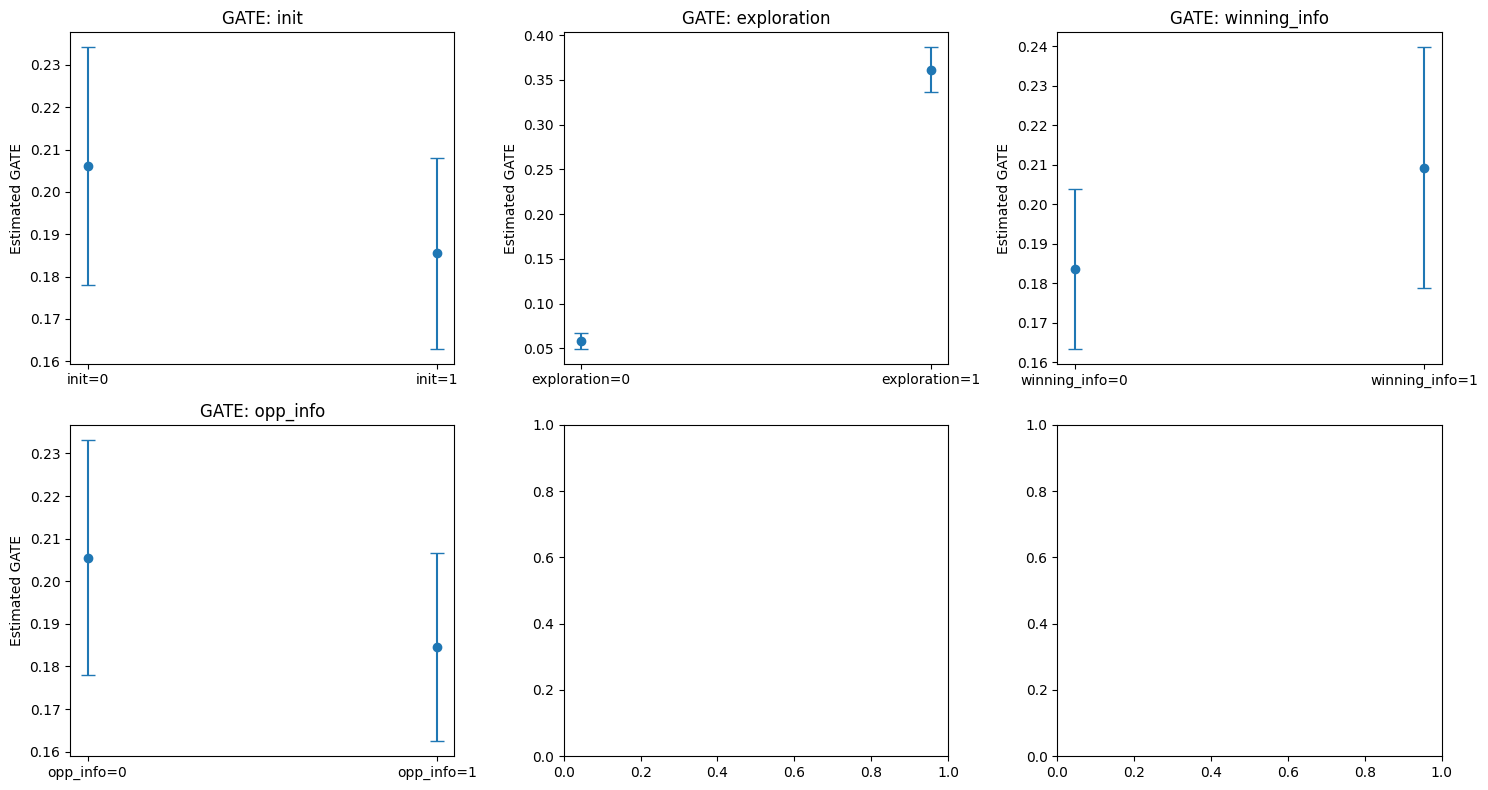

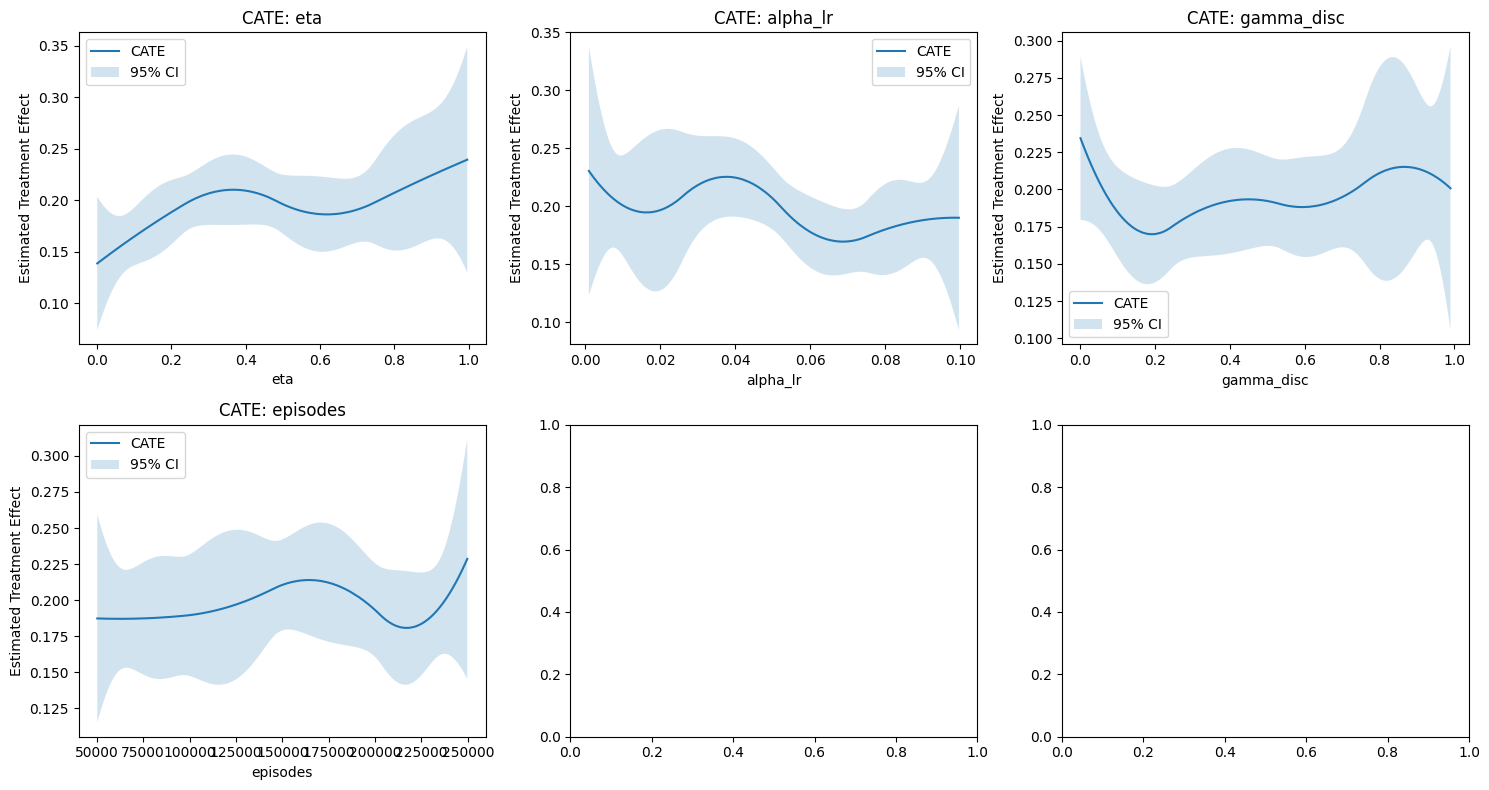

In [3]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# DoubleML
import doubleml as dml
from doubleml import DoubleMLData, DoubleMLIRM

# LightGBM
from lightgbm import LGBMRegressor, LGBMClassifier

# For spline expansions (CATE)
import patsy


def main():
    # ------------------------------------------------------------------------------
    # 1) Setup: Create output directory
    # ------------------------------------------------------------------------------
    os.makedirs("experiment2", exist_ok=True)

    # ------------------------------------------------------------------------------
    # 2) Load Experiment 2 Data
    # ------------------------------------------------------------------------------
    df = pd.read_csv("experiment2/data.csv")

    # ------------------------------------------------------------------------------
    # 3) Treatment and Covariates
    # ------------------------------------------------------------------------------
    # Define treatment
    df["D"] = (df["auction_type"] == "second").astype(int)

    # Continuous covariates
    cont_cols = ["eta", "alpha", "gamma", "episodes"]

    # Binary covariates
    df["init"] = (df["init"] == "random").astype(int)
    df["exploration"] = (df["exploration"] == "egreedy").astype(int)
    df["median_opp_past_bid_index"] = df["median_opp_past_bid_index"].astype(int)
    df["winner_bid_index_state"] = df["winner_bid_index_state"].astype(int)
    df["asynchronous"] = df["asynchronous"].astype(int)

    binary_cols = ["init", "exploration", "median_opp_past_bid_index", "winner_bid_index_state", "asynchronous"]

    # All covariates
    X_cols = cont_cols + binary_cols

    # Define outcomes
    outcomes = ["avg_rev_last_1000", "time_to_converge", "avg_regret_of_seller"]

    # ------------------------------------------------------------------------------
    # 4) Loop Over Outcomes
    # ------------------------------------------------------------------------------
    for outcome in outcomes:
        print(f"\n========== Inference for Outcome: {outcome} ==========")

        # Define current outcome
        df["Y"] = df[outcome]

        # ------------------------------------------------------------------------------
        # 5) Prepare DoubleML Data and Model
        # ------------------------------------------------------------------------------
        dml_data = DoubleMLData(
            df,
            y_col="Y",
            d_cols="D",
            x_cols=X_cols
        )

        # Define learners
        ml_g = LGBMRegressor(verbose=-1, random_state=123)
        ml_m = LGBMClassifier(verbose=-1, random_state=123)

        # Initialize DoubleML IRM Model
        dml_irm = DoubleMLIRM(
            dml_data,
            ml_g=ml_g,
            ml_m=ml_m,
            n_folds=3,
            score="ATE"
        )

        # Fit the model
        dml_irm.fit()

        # ------------------------------------------------------------------------------
        # 6) Print and Save ATE Results
        # ------------------------------------------------------------------------------
        print(f"========== ATE Results for {outcome} ==========")
        print(dml_irm.summary)

        # ------------------------------------------------------------------------------
        # 7) GATEs for Binary Covariates
        # ------------------------------------------------------------------------------
        print(f"Generating GATE plots for {outcome}...")
        n_bin = len(binary_cols)
        nrows_gate = int(np.ceil(n_bin / 3))  # up to 3 columns
        ncols_gate = min(n_bin, 3)

        fig_gate, axes_gate = plt.subplots(nrows=nrows_gate, ncols=ncols_gate,
                                           figsize=(5 * ncols_gate, 4 * nrows_gate))

        if n_bin == 1:
            axes_gate = np.array([axes_gate])

        for i, bin_col in enumerate(binary_cols):
            groups_df = df[[bin_col]].astype("category")
            gate_obj = dml_irm.gate(groups=groups_df)
            ci_95_gate = gate_obj.confint(level=0.95)

            effects = ci_95_gate["effect"]
            lower_95 = ci_95_gate["2.5 %"]
            upper_95 = ci_95_gate["97.5 %"]

            ax = axes_gate.flatten()[i] if n_bin > 1 else axes_gate[0]
            x_positions = [0, 1]
            ax.errorbar(
                x_positions, effects,
                yerr=[effects - lower_95, upper_95 - effects],
                fmt="o", capsize=5
            )
            ax.set_title(f"GATE: {bin_col}")
            ax.set_xticks(x_positions)
            ax.set_xticklabels([f"{bin_col}=0", f"{bin_col}=1"])
            ax.set_ylabel("Estimated GATE")

        fig_gate.tight_layout()
        gate_plot_path = os.path.join("experiment2", f"gate_plots_{outcome}.png")
        fig_gate.savefig(gate_plot_path, bbox_inches="tight")
        plt.close(fig_gate)
        print(f"GATE plots for {outcome} saved to: {gate_plot_path}")

        # ------------------------------------------------------------------------------
        # 8) CATEs for Continuous Covariates
        # ------------------------------------------------------------------------------
        print(f"Generating CATE plots for {outcome}...")
        n_cont = len(cont_cols)
        nrows_cate = int(np.ceil(n_cont / 3))
        ncols_cate = min(n_cont, 3)

        fig_cate, axes_cate = plt.subplots(nrows=nrows_cate, ncols=ncols_cate,
                                           figsize=(5 * ncols_cate, 4 * nrows_cate))

        if n_cont == 1:
            axes_cate = np.array([axes_cate])

        for i, cont_col in enumerate(cont_cols):
            design_matrix = patsy.dmatrix(f"bs({cont_col}, df=5, degree=2)", df)
            spline_basis = pd.DataFrame(design_matrix)

            cate_obj = dml_irm.cate(basis=spline_basis)
            ci_95_cate = cate_obj.confint(basis=spline_basis, level=0.95)

            effects_cate = ci_95_cate["effect"].values
            lower_95_cate = ci_95_cate["2.5 %"].values
            upper_95_cate = ci_95_cate["97.5 %"].values

            x_values = df[cont_col].values
            idx_sort = np.argsort(x_values)

            x_sorted = x_values[idx_sort]
            eff_sorted = effects_cate[idx_sort]
            low_sorted = lower_95_cate[idx_sort]
            up_sorted = upper_95_cate[idx_sort]

            ax_cate = axes_cate.flatten()[i] if n_cont > 1 else axes_cate[0]
            ax_cate.plot(x_sorted, eff_sorted, label="CATE")
            ax_cate.fill_between(x_sorted, low_sorted, up_sorted,
                                 alpha=0.2, label="95% CI")
            ax_cate.set_title(f"CATE: {cont_col}")
            ax_cate.set_xlabel(cont_col)
            ax_cate.set_ylabel("Estimated Treatment Effect")
            ax_cate.legend()

        fig_cate.tight_layout()
        cate_plot_path = os.path.join("experiment2", f"cate_plots_{outcome}.png")
        fig_cate.savefig(cate_plot_path, bbox_inches="tight")
        plt.close(fig_cate)
        print(f"CATE plots for {outcome} saved to: {cate_plot_path}")

    print("\nInference complete. All results saved in 'experiment2/' folder.")


if __name__ == "__main__":
    main()
